In [1]:
import pandas as pd
from numpy import nan
import numpy as np
import matplotlib.pyplot as plt

import constant

# Windmill Preprocessing
## Clean and prepare windmill data for GIS

In [2]:
# static cols
cols = ['GSRN','Turbine_type','Parent_GSRN','BBR_municipal','Placement','UTM_x','UTM_y','Capacity_kw','Rotor_diameter','Navhub_height','In_service','Out_service']

In [3]:
windmills = pd.read_parquet('data/ITU_DATA/masterdatawind.parquet', columns=cols)

In [4]:
windmills.sort_values(["In_service"])

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,In_service,Out_service
79776,571313114900743984,H,None,707,None,NaN,NaN,10.0,7.1,21.4,1816-03-29 05:56:08.067,NaT
85086,571313174116253585,W,None,265,LAND,694932.0,6175477.0,850.0,52.0,44.0,1816-03-29 05:56:08.067,NaT
85087,571313174116253585,W,None,265,LAND,694932.0,6175477.0,850.0,52.0,44.0,1816-03-29 05:56:08.067,NaT
79777,571313114900743984,H,None,707,None,NaN,NaN,10.0,7.1,21.4,1816-03-29 05:56:08.067,NaT
6507,570714700000011283,W,None,400,LAND,505771.2,6109811.3,30.0,0.1,0.1,1977-12-22 00:00:00.000,2002-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...
85021,571313174002139191,H,None,336,None,NaN,NaN,5.0,2.9,3.1,NaT,NaT
85139,571313179100992129,H,None,250,None,NaN,NaN,25.0,11.0,23.5,NaT,NaT
85140,571313179100992129,H,None,250,None,NaN,NaN,25.0,11.0,23.5,NaT,NaT
85141,571313179100992129,H,None,250,None,NaN,NaN,25.0,11.0,23.5,NaT,NaT


### Select windmills still service

In [ ]:
windmills = windmills[windmills['Out_service'].isna()]
windmills = windmills.drop(columns = "Out_service")

### Remove duplicated data
Windmills have duplicated data by different reviewers.    

In [ ]:
windmills.drop_duplicates(subset = "GSRN", keep = 'first', ignore_index = True, inplace = True)

Household windmills has no coordinates, filter it out

In [ ]:
windmills = windmills[windmills['Turbine_type'] != 'H']

### Fill Turbine park xy by the CENTRIODs of their children's.
### Fill Turbine park Rotor_diameter, Navhub_height by the mean of their children's.

In [ ]:
windmills_M = windmills[windmills['Turbine_type'] == 'M']
aggs = {'UTM_x':lambda x : x.mean(),
        'UTM_y':lambda x : x.mean()}
windmills_PM = windmills_M.groupby(['Parent_GSRN'], as_index = False).agg(aggs).rename(columns={'Parent_GSRN':'GSRN','UTM_x':'x_c','UTM_y':'y_c'})

temp_1 = pd.DataFrame(windmills_M.groupby("Parent_GSRN")["Rotor_diameter"].apply(list)).reset_index()
temp_2 = pd.DataFrame(windmills_M.groupby("Parent_GSRN")["Navhub_height"].apply(list)).reset_index()
temp_1 = pd.merge(temp_1, temp_2, on="Parent_GSRN")
temp_1 = temp_1.rename({"Parent_GSRN":"GSRN","Rotor_diameter":"Rotor_diameter_mean", "Navhub_height":"Navhub_height_mean"}, axis=1)
temp_1["Rotor_diameter_mean"] = temp_1["Rotor_diameter_mean"].apply(lambda x: np.mean(x).astype(float))
temp_1["Navhub_height_mean"] = temp_1["Navhub_height_mean"].apply(lambda x: np.mean(x).astype(float))
windmills_PM = pd.merge(windmills_PM, temp_1, on="GSRN")
windmills_PM

In [ ]:
windmills = pd.merge(windmills, windmills_PM, on='GSRN', how='left')
# location
windmills[['UTM_x']] = windmills.apply(lambda x: x[['UTM_x']].fillna(value = x['x_c']), axis=1)[['UTM_x']]
windmills[['UTM_y']] = windmills.apply(lambda x: x[['UTM_y']].fillna(value = x['y_c']), axis=1)[['UTM_y']]
windmills[['Rotor_diameter']] = windmills.apply(lambda x: x[['Rotor_diameter']].fillna(value = x['Rotor_diameter_mean']), axis=1)[['Rotor_diameter']]
windmills[['Navhub_height']] = windmills.apply(lambda x: x[['Navhub_height']].fillna(value = x['Navhub_height_mean']), axis=1)[['Navhub_height']]
windmills = windmills.drop(columns=['x_c','y_c','Rotor_diameter_mean','Navhub_height_mean'])

Filter out other no coordinate windmills or parks

In [ ]:
windmills = windmills[~windmills['UTM_x'].isnull()]
windmills = windmills[~windmills['UTM_y'].isnull()]
windmills.shape

- H: Household turbine : No UTM_xy locations 
- W: Single turbine : full data
- P: Turbine park : No UTM_xy locations
- M: Turbine in a park : No power record in settlement data


In [ ]:
print('Household: ',windmills[windmills['Turbine_type'] == 'H'].shape)
print('Single: ',windmills[windmills['Turbine_type'] == 'W'].shape)
print('Park: ',windmills[windmills['Turbine_type'] == 'P'].shape)
print('In a Park: ',windmills[windmills['Turbine_type'] == 'M'].shape)

Cause a bug in ArcGIS file import, we need to add a 'z' at the end of GSRN and Parent_GSRN

In [ ]:
windmills['GSRN'] = [x+'z' for x in windmills['GSRN']]
windmills['Parent_GSRN'].fillna('',inplace = True)
windmills['Parent_GSRN'] = [x+'z' for x in windmills['Parent_GSRN']]

In [ ]:
windmills.to_csv('data/windmill_gis.csv', index=False)

## After ArcGIS data extraction 
Merge data

In [31]:
windmills_gis = pd.read_excel('data/windmill_extract.xlsx')
windmills_gis.head(3)

,OBJECTID,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,In_service,Aspect,Slope,Elevation,grid,LABEL3,Landcover
0,1,570714700000005619z,W,z,330,LAND,642278.20,6134407.00,55.0,16.0,18.0,1984-11-24,225.0,3.035724,23.0,817,Non-irrigated arable land,211
1,2,570715000000049002z,M,570715000000048869z,550,LAND,478674.48,6099264.00,600.0,42.0,45.0,1995-05-03,45.0,1.012750,12.0,1190,Non-irrigated arable land,211
2,3,570715000000055430z,W,z,430,LAND,572444.17,6106876.88,225.0,27.0,30.0,1993-10-28,135.0,1.012750,46.0,940,Non-irrigated arable land,211


In [32]:
windmills_gis["Aspect"] = windmills_gis["Aspect"]*(np.pi/180)

In [34]:
windmills_grid = pd.read_excel('data/windmill_grid.xlsx')[["GSRN","grid"]]
windmills_grid.head(3)

,GSRN,grid
0,570715000000052248z,857.0
1,570715000000056024z,1235.0
2,570715000000036705z,1326.0


In [35]:
windmills_grid = windmills_grid[~windmills_grid['grid'].isna()]

In [36]:
windmills_grid['grid'] = windmills_grid['grid'].apply(int)
windmills_grid["GSRN"] = windmills_grid["GSRN"].apply(str)

In [37]:
windmills = pd.read_csv('data/windmill_gis.csv')
windmills.head(3)

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,In_service
0,570714700000000027z,M,570714700000050459z,101,LAND,720898.353,6171174.877,225.0,27.0,30.0,1993-02-03
1,570714700000000034z,M,570714700000050459z,101,LAND,720993.352,6171226.877,225.0,27.0,30.0,1993-02-03
2,570714700000000041z,M,570714700000050466z,101,LAND,727504.304,6178385.864,600.0,44.0,50.0,1996-07-11


In [38]:
windmills = pd.merge(windmills, windmills_grid, on="GSRN", how='inner')
len(windmills)

6902

In [39]:
cols = ['GSRN', 'Aspect', 'Slope', 'Elevation', 'Landcover']
windmills = pd.merge(windmills, windmills_gis[cols], on="GSRN", how='left')
len(windmills)

6902

In [40]:
windmills["GSRN"] = windmills["GSRN"].apply(str)
windmills["Parent_GSRN"] = windmills["Parent_GSRN"].apply(str)
windmills["GSRN"] = windmills["GSRN"].apply(lambda x : x[:len(x)-1])
windmills["Parent_GSRN"] = windmills["Parent_GSRN"].apply(lambda x : x[:len(x)-1])

In [41]:
windmills["Landcover"] = windmills["Landcover"].fillna(-1)
windmills["Landcover"] = windmills["Landcover"].apply(int)

In [42]:
roughness_dic = {112:0.1, 121:0.1, 123:0.1, 131:0.0005,  133:0.1, 142:0.1,211:0.005, 222:0.05, 231:0.03, 242:0.3,243:0.3, 312:0.5, 313:0.5, 321:0.03, 322:0.03, 324:0.6, 331:0.0003, 411:0.005, 412:0.0005, 421:0.005, 423:0.0005, 512:0.000001,523:0.000001, -1:0.000001}

In [44]:
windmills['Roughness'] = windmills['Landcover'].apply(lambda x: roughness_dic[x])

In [45]:
windmills['Slope'] = round(windmills['Slope'],3)
windmills['Aspect'] = round(windmills['Aspect'],3)
windmills['Elevation'] = round(windmills['Elevation'],3)
windmills.fillna({'Slope':0, 'Aspect':-1, 'Elevation':0}, inplace=True)
windmills = windmills.drop(columns=["Landcover"])

In [46]:
windmills.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6902 entries, 0 to 6901
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GSRN            6902 non-null   object 
 1   Turbine_type    6902 non-null   object 
 2   Parent_GSRN     6902 non-null   object 
 3   BBR_municipal   6902 non-null   int64  
 4   Placement       6902 non-null   object 
 5   UTM_x           6902 non-null   float64
 6   UTM_y           6902 non-null   float64
 7   Capacity_kw     6902 non-null   float64
 8   Rotor_diameter  6861 non-null   float64
 9   Navhub_height   6902 non-null   float64
 10  In_service      6900 non-null   object 
 11  grid            6902 non-null   int64  
 12  Aspect          6902 non-null   float64
 13  Slope           6902 non-null   float64
 14  Elevation       6902 non-null   float64
 15  Roughness       6902 non-null   float64
dtypes: float64(9), int64(2), object(5)
memory usage: 916.7+ KB


In [47]:
windmills.to_csv('data/windmill_cleaned.csv', index=False)

# Extract 2019 yearly max VAERDI

In [48]:
dtype = {"GSRN":str, "Turbine_type":str, "Parent_GSRN":str, "BBR_municipal":int, "Placement": str, "Capacity_kw":float, "Rotor_diameter":float, "Navhub_height":float, "Elevation":float, "Slope":float, "Aspect":float, "grid":int, "Roughness":float}
windmills = pd.read_csv('data/windmill_cleaned.csv', dtype=dtype)

In [49]:
len(windmills)

6902

In [50]:
settlement = pd.read_parquet(constant.settlement_2019_path)

In [51]:
settlement = settlement[settlement["GSRN"].isin(windmills["GSRN"].to_list())]
settlement

,GSRN,VAERDI,TIME_CET
0,570715000000023965,330.300,2019-01-27 19:00:00
1,570715000000023965,103.900,2019-01-27 20:00:00
2,570715000000051241,2.800,2019-04-16 15:00:00
3,570715000000023965,60.600,2019-01-27 21:00:00
4,570715000000023965,7.000,2019-01-27 22:00:00
...,...,...,...
45563225,570715000000017704,2.537,2019-12-30 21:00:00
45563226,570715000000017704,3.166,2019-12-30 22:00:00
45563227,570715000000017704,5.250,2019-12-30 23:00:00
45563228,570715000000017704,3.718,2019-12-31 00:00:00


In [52]:
settlement = settlement.groupby("GSRN", as_index=False)["VAERDI"].max().rename({"VAERDI":"max_VAERDI"}, axis=1)

In [53]:
windmills = pd.merge(windmills, settlement, on="GSRN")

In [54]:
len(windmills)

3614

In [55]:
len(np.unique(settlement["GSRN"]))

3614

### Filter max_VAERDI>0

In [56]:
windmills = windmills[windmills["max_VAERDI"] > 0]

In [57]:
windmills["max_VAERDI"] = round(windmills["max_VAERDI"],0)
windmills[["max_VAERDI"]] = windmills[["max_VAERDI"]].apply(lambda x: round(x / 10**(len(str(int(x)))-1), 0) * 10**(len(str(int(x)))-1), axis=1)


In [58]:
windmills

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,In_service,grid,Aspect,Slope,Elevation,Roughness,max_VAERDI
0,570714700000000140,W,NaN,167,LAND,719970.0,6167337.0,660.0,47.0,40.0,2000-05-18,652,-0.017,0.000,2.0,0.100,700.0
1,570714700000000157,W,NaN,167,LAND,720031.0,6167484.0,660.0,47.0,40.0,2000-05-18,652,-0.017,0.000,2.0,0.100,700.0
2,570714700000000317,W,NaN,219,LAND,704171.0,6199826.0,660.0,47.0,40.0,2001-05-14,696,-0.017,0.000,21.0,0.005,700.0
3,570714700000000324,W,NaN,219,LAND,704221.0,6199967.0,660.0,47.0,40.0,2001-05-14,696,1.571,1.432,20.0,0.005,700.0
4,570714700000000331,W,NaN,219,LAND,704272.0,6200109.0,660.0,47.0,40.0,2001-05-14,696,-0.017,0.000,19.0,0.005,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3609,571313174001699887,W,NaN,360,LAND,644782.0,6073093.0,3600.0,126.0,87.0,2018-02-13,771,-0.017,0.000,1.0,0.005,4000.0
3610,571313174001699894,W,NaN,360,LAND,644459.0,6073175.0,3600.0,126.0,87.0,2018-02-08,771,-0.017,0.000,1.0,0.005,4000.0
3611,571313174001699900,W,NaN,360,LAND,644136.0,6073257.0,3600.0,126.0,87.0,2018-02-08,771,1.571,1.432,1.0,0.005,4000.0
3612,571313174001764448,W,NaN,320,LAND,702483.0,6132921.0,225.0,29.0,31.5,2018-11-21,650,-0.017,0.000,22.0,0.005,200.0


In [59]:
print('Household: ',windmills[windmills['Turbine_type'] == 'H'].shape)
print('In a Park: ',windmills[windmills['Turbine_type'] == 'M'].shape)
print('Single: ',windmills[windmills['Turbine_type'] == 'W'].shape)
print('Park: ',windmills[windmills['Turbine_type'] == 'P'].shape)

Household:  (0, 17)
In a Park:  (269, 17)
Single:  (3065, 17)
Park:  (242, 17)


In [60]:
print('Onshore Single: ',windmills[windmills['Turbine_type'] == 'W'][windmills['Placement'] == 'LAND'].shape)
print('Offshore Single: ',windmills[windmills['Turbine_type'] == 'W'][windmills['Placement'] == 'HAV'].shape)
print('Onshore Park: ',windmills[windmills['Turbine_type'] == 'P'][windmills['Placement'] == 'LAND'].shape)
print('Offshore Park: ',windmills[windmills['Turbine_type'] == 'P'][windmills['Placement'] == 'HAV'].shape)

Onshore Single:  (3049, 17)
Offshore Single:  (16, 17)
Onshore Park:  (229, 17)
Offshore Park:  (13, 17)


In [61]:
windmills.to_csv('data/windmill_cleaned.csv', index=False)

# Windmill Classify by max_VAERDI

In [47]:
dtype = {"GSRN":str, "Turbine_type":str, "Parent_GSRN":str, "BBR_municipal":int, "Placement": str, "Capacity_kw":float, "Rotor_diameter":float, "Navhub_height":float, "Elevation":float, "Slope":float, "Aspect":float, "grid":int, "Roughness":float}
windmills = pd.read_csv('data/windmill_cleaned.csv', dtype=dtype)

In [48]:
windmill_SL = windmills[windmills["Turbine_type"] == "W"][windmills["Placement"] == "LAND"]
windmill_SH = windmills[windmills["Turbine_type"] == "W"][windmills["Placement"] == "HAV"]
windmill_PL = windmills[windmills["Turbine_type"]=="P"][windmills["Placement"]=="LAND"]
windmill_PH = windmills[windmills["Turbine_type"]=="P"][windmills["Placement"]=="HAV"]

In [49]:
SL_plt = windmill_SL.groupby("max_VAERDI", as_index=False)["GSRN"].count()
SH_plt = windmill_SH.groupby("max_VAERDI", as_index=False)["GSRN"].count()
PL_plt = windmill_PL.groupby("max_VAERDI", as_index=False)["GSRN"].count()
PH_plt = windmill_PH.groupby("max_VAERDI", as_index=False)["GSRN"].count()

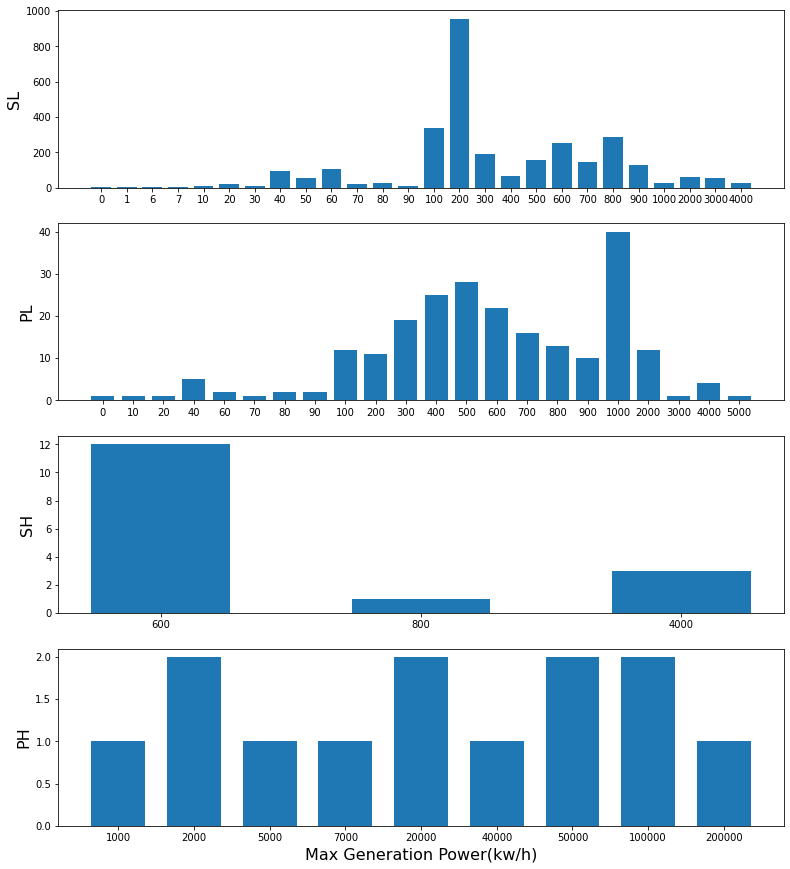

In [71]:
fig, ax = plt.subplots(4, 1, figsize=(13,15))
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.2)

names = ["SL", "PL", "SH","PH"]
for i, df_plt in enumerate([SL_plt, PL_plt, SH_plt, PH_plt]):
    x = np.linspace(0, len(df_plt), len(df_plt))
    y = df_plt["GSRN"]
    ax[i].bar(x, y, 0.8)
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(df_plt["max_VAERDI"].astype(int))
    ax[i].set_ylabel(names[i])

# plt.ylabel("Count of Windmills")
plt.xlabel("Max Generation Power(kw/h)")
plt.show()

In [52]:
from sklearn.cluster import KMeans
from tools import normalize_zcenter

In [67]:
cols = "max_VAERDI"
windmill_SL["max_VAERDI_normal"] = normalize_zcenter(windmill_SL["max_VAERDI"])
windmill_SL['cls'] = KMeans().fit_predict(np.asarray(windmill_SL["max_VAERDI_normal"]).reshape(-1,1))
windmill_SL.groupby("cls", as_index=False)["GSRN"].count()

,cls,GSRN
0,0,694
1,1,57
2,2,556
3,3,60
4,4,28
5,5,443
6,6,955
7,7,256


In [60]:
windmill_SH["max_VAERDI_normal"] = normalize_zcenter(windmill_SH["max_VAERDI"])
windmill_SH['cls'] = KMeans().fit_predict(np.asarray(windmill_SH["max_VAERDI_normal"]).reshape(-1,1))
windmill_SH.groupby("cls", as_index=False)["GSRN"].count()

,cls,GSRN
0,0,12
1,1,3
2,2,1


In [55]:
windmill_PL["max_VAERDI_normal"] = normalize_zcenter(windmill_PL["max_VAERDI"])
windmill_PL['cls'] = KMeans().fit_predict(np.asarray(windmill_PL["max_VAERDI_normal"]).reshape(-1,1))
windmill_PL.groupby("cls", as_index=False)["GSRN"].count()

,cls,GSRN
0,0,51
1,1,4
2,2,72
3,3,12
4,4,38
5,5,50
6,6,1
7,7,1


In [81]:
windmill_PH["max_VAERDI_normal"] = normalize_zcenter(windmill_PH["max_VAERDI"])
windmill_PH['cls'] = KMeans().fit_predict(np.asarray(windmill_PH["max_VAERDI_normal"]).reshape(-1,1))
windmill_PH.groupby("cls", as_index=False)["GSRN"].count()

,cls,GSRN
0,0,3
1,1,2
2,2,1
3,3,2
4,4,2
5,5,1
6,6,1
7,7,1


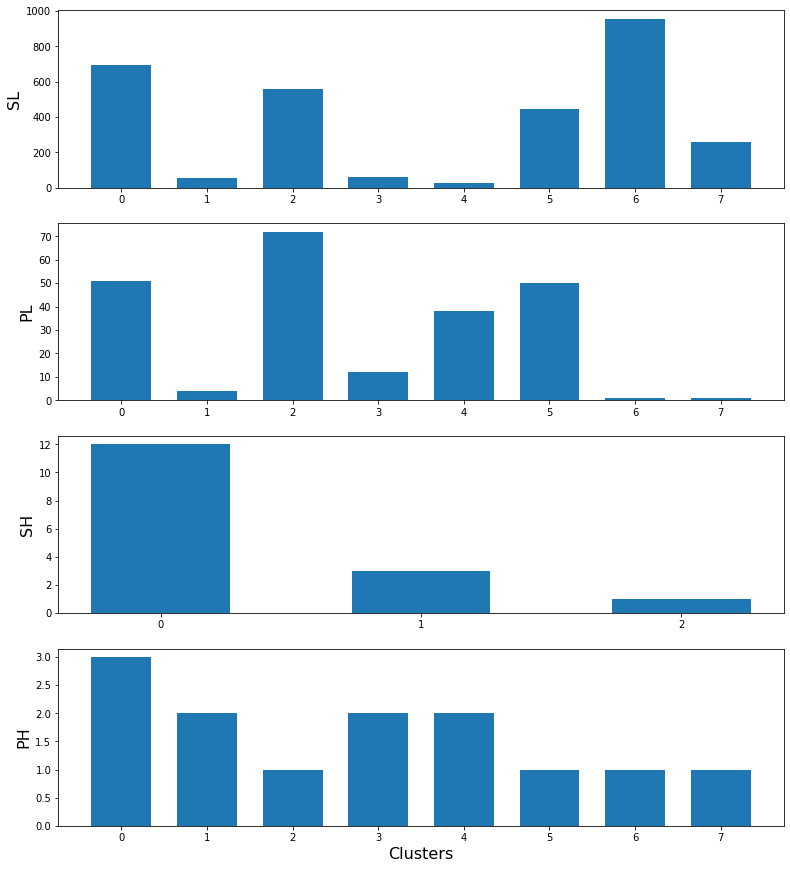

In [83]:
fig, ax = plt.subplots(4, 1, figsize=(13,15))
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.2)

names = ["SL", "PL", "SH","PH"]
for i, df_plt in enumerate([windmill_SL, windmill_PL, windmill_SH, windmill_PH]):
    df_plt = df_plt.groupby("cls", as_index=False)["GSRN"].count()
    x = np.linspace(0, len(df_plt), len(df_plt))
    y = df_plt["GSRN"]
    ax[i].bar(x, y, 0.8)
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(df_plt["cls"].astype(int))
    ax[i].set_ylabel(names[i])

# plt.ylabel("Count of Windmills")
plt.xlabel("Clusters")
plt.show()

### Select max_VAERDI cls == 6

In [68]:
windmill_SL_SC = windmill_SL[windmill_SL["cls"] == 6]
windmill_SL_SC

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,In_service,grid,Aspect,Slope,Elevation,Roughness,max_VAERDI,max_VAERDI_normal,cls
43,570714700000002601,W,NaN,400,LAND,485197.9,6117922.2,225.0,27.0,31.5,1992-04-29,1191,-0.017,0.000,11.0,0.005,200.0,-0.447386,6
44,570714700000002618,W,NaN,400,LAND,485393.9,6117962.9,225.0,27.0,31.5,1992-04-29,1191,1.249,2.264,10.0,0.005,200.0,-0.447386,6
45,570714700000002625,W,NaN,400,LAND,485589.8,6118003.6,225.0,27.0,31.5,1992-04-29,1191,-0.017,0.000,10.0,0.005,200.0,-0.447386,6
46,570714700000002731,W,NaN,400,LAND,502727.5,6099199.3,225.0,29.0,31.5,1996-12-09,1107,0.785,1.013,18.0,0.005,200.0,-0.447386,6
47,570714700000002748,W,NaN,400,LAND,502881.6,6099272.0,225.0,29.0,31.5,1996-12-09,1107,-0.017,0.000,18.0,0.005,200.0,-0.447386,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,570715000000087141,W,NaN,756,LAND,509907.0,6228501.0,850.0,52.0,54.0,2009-07-08,1198,1.571,1.432,61.0,0.030,200.0,-0.447386,6
2931,570715000000088513,W,NaN,330,LAND,642383.2,6140088.0,200.0,23.0,30.0,2007-02-01,817,-0.017,0.000,20.0,0.005,200.0,-0.447386,6
3242,570715000001589897,W,NaN,479,LAND,597837.0,6093431.0,900.0,61.0,46.0,2017-12-20,898,3.927,1.013,1.0,0.005,200.0,-0.447386,6
3488,571313154314482116,W,NaN,479,LAND,602400.0,6115800.0,850.0,52.0,54.0,2014-09-11,899,-0.017,0.000,104.0,0.005,200.0,-0.447386,6


In [69]:
windmill_SL_SC.to_csv("data/windmill_SL_SC.csv", index=False)